In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
# from voltron.robinhood_utils import GetStockData
import os
# import robin_stocks.robinhood as r
import pickle5 as pickle

sns.set_style("whitegrid")
sns.set_palette("bright")

sns.set(font_scale=2.0)
sns.set_style('whitegrid')

import sys
sys.path.append("../")
from voltron.likelihoods import VolatilityGaussianLikelihood
from voltron.models import SingleTaskVariationalGP as SingleTaskCopulaProcessModel
from voltron.kernels import BMKernel, VolatilityKernel
from voltron.models import BMGP, VoltronGP
from gpytorch.kernels import ScaleKernel, RBFKernel, MaternKernel

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.
Warning no robinhood utils.


In [2]:
# with open("../../stock_data.pkl", "rb") as handle:
#     raw_data = pickle.load(handle)
    
with open("./stock_data.pkl", "rb") as handle:
    raw_data = pickle.load(handle)

In [3]:
np.unique(raw_data["symbol"])

array(['AAPL', 'F', 'JPM', 'SBUX', 'TSLA', 'VIRT'], dtype=object)

# Header

In [4]:
ntest = 200
ntrain = 200
tckrs = ['TSLA', "F", "JPM", "SBUX", 'AAPL', "VIRT"]
tckr = "VIRT"
span = "5year"
interval = 'day'
T = 5.

## Data Setup

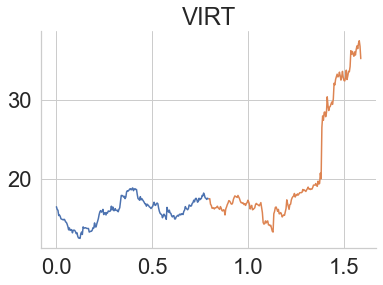

In [5]:
idx = -2
# data = GetStockData(tckr, span=span, interval=interval)
data = raw_data[raw_data["symbol"] == tckr]

ts = torch.linspace(0, T, data.shape[0])
train_x = ts[:ntrain]
test_x = ts[ntrain:(ntrain+ntest)]

y = torch.FloatTensor(data['close_price'].to_numpy())
train_y = y[:ntrain]
test_y = y[ntrain:(ntrain+ntest)]

dt = ts[1] - ts[0]

plt.plot(train_x, train_y)
plt.plot(test_x, test_y)
plt.title(tckr);
sns.despine()
plt.show()

In [6]:
log_returns = torch.log(train_y[1:]/train_y[:-1])

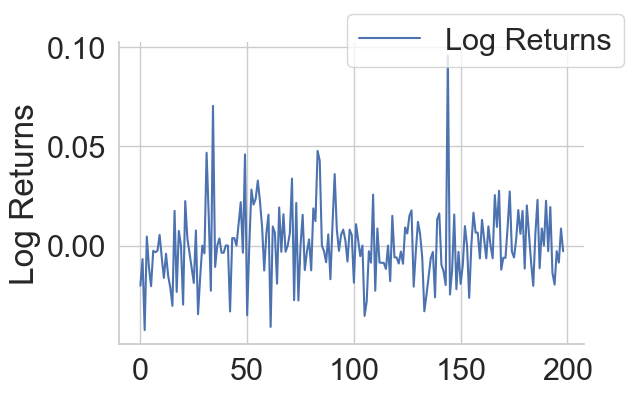

In [7]:
fig, ax = plt.subplots(dpi=100)
ax.plot(log_returns, label='Log Returns')

ax.set_ylabel("Log Returns")

fig.legend()
sns.despine()

## Now apply GCPV

In [9]:
likelihood = VolatilityGaussianLikelihood()
likelihood.raw_a.data -= 6

# covar_module = MaternKernel(nu=0.5)
covar_module = BMKernel()
model = SingleTaskCopulaProcessModel(
    init_points=train_x[:-1].view(-1,1), likelihood=likelihood, use_piv_chol_init=False,
    mean_module = gpytorch.means.ConstantMean(), covar_module=covar_module, learn_inducing_locations=False
)
# model.covar_module.base_kernel.raw_lengthscale.data = torch.tensor([[-5.]])

In [10]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 500


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {"params": model.parameters()}, 
    # {"params": likelihood.parameters(), "lr": 0.1}
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
# num_data refers to the number of training datapoints
mll = gpytorch.mlls.VariationalELBO(likelihood, model, train_y.numel())

In [11]:
print_every = 50
for i in range(training_iterations):
    # Zero backpropped gradients from previous iteration
    optimizer.zero_grad()
    # Get predictive output
    with gpytorch.settings.num_gauss_hermite_locs(75):
        output = model(train_x[:-1])
        # Calc loss and backprop gradients
        loss = -mll(output, log_returns)
        loss.backward()
        if i % print_every == 0:
            print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

Iter 1/500 - Loss: -2.493
Iter 51/500 - Loss: -2.563
Iter 101/500 - Loss: -2.565
Iter 151/500 - Loss: -2.566
Iter 201/500 - Loss: -2.566
Iter 251/500 - Loss: -2.566
Iter 301/500 - Loss: -2.566
Iter 351/500 - Loss: -2.566
Iter 401/500 - Loss: -2.566
Iter 451/500 - Loss: -2.566


In [12]:
model.eval();
likelihood.eval();
predictive = model(train_x)
pred_scale = likelihood(predictive, return_gaussian=False).scale.mean(0).detach()
samples = likelihood(predictive, return_gaussian=False).scale.detach()

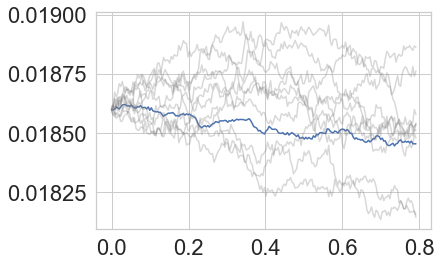

In [16]:
plt.plot(train_x, pred_scale)
plt.plot(train_x, samples.t(), color = "gray", alpha = 0.3)

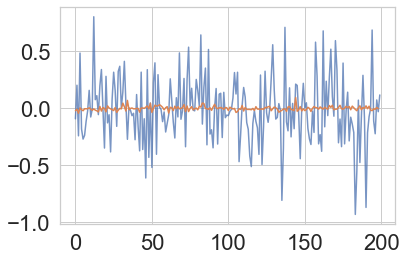

In [17]:
plt.plot(torch.randn(train_y.shape[0])*pred_scale / dt**0.5, alpha=0.75)
plt.plot(log_returns)

## Now Do Forward Predictions with Voltron

In [18]:
pred_scale = pred_scale / dt**0.5

In [19]:
vol_lh = gpytorch.likelihoods.GaussianLikelihood()
vol_lh.noise.data = torch.tensor([1e-6])
vol_model = BMGP(train_x, pred_scale.log(), vol_lh)

optimizer = torch.optim.Adam([
    {'params': vol_model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.01)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(vol_lh, vol_model)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = vol_model(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, pred_scale.log())
    loss.backward()
#     print(loss.item(), model.covar_module.vol.item())
    optimizer.step()
    
print((vol_model.covar_module.raw_vol))
print(vol_model.mean_module.constant.data.exp())

Parameter containing:
tensor([-4.6074], requires_grad=True)
tensor([0.2951])


In [20]:
from voltron.means import LogLinearMean

In [21]:
voltron_lh = gpytorch.likelihoods.GaussianLikelihood()
voltron = VoltronGP(train_x, train_y.log(), voltron_lh, pred_scale)
voltron.mean_module = LogLinearMean(1)
voltron.mean_module.initialize_from_data(train_x, train_y.log())
voltron.likelihood.raw_noise.data = torch.tensor([1e-6])
voltron.vol_lh = vol_lh
voltron.vol_model = vol_model

grad_flags = [False, True, True, True, False, False, False]

for idx, p in enumerate(voltron.parameters()):
    p.requires_grad = grad_flags[idx]
    
voltron.train();
voltron_lh.train();
voltron.vol_lh.train();
voltron.vol_model.train();

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': voltron.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(voltron_lh, voltron)

for i in range(500):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = voltron(train_x)
    # Calc loss and backprop gradients
    loss = -mll(output, train_y.log())
    loss.backward()
    # print(loss.item())
    optimizer.step()

## Predict

In [22]:
%pdb

Automatic pdb calling has been turned ON


In [23]:
nvol = 10
npx = 10
vol_paths = torch.zeros(nvol, ntest)
px_paths = torch.zeros(npx*nvol, ntest)

voltron.vol_model.eval();
voltron.eval();

for vidx in range(nvol):
    print(vidx)
    vol_pred = voltron.vol_model(test_x).sample().exp()
    vol_paths[vidx, :] = vol_pred.detach()
    
    px_pred = voltron.GeneratePrediction(test_x, vol_pred, npx).exp()
    px_paths[vidx*npx:(vidx*npx+npx), :] = px_pred.detach().T

0
1
2
3
4
5
6
7
8
9


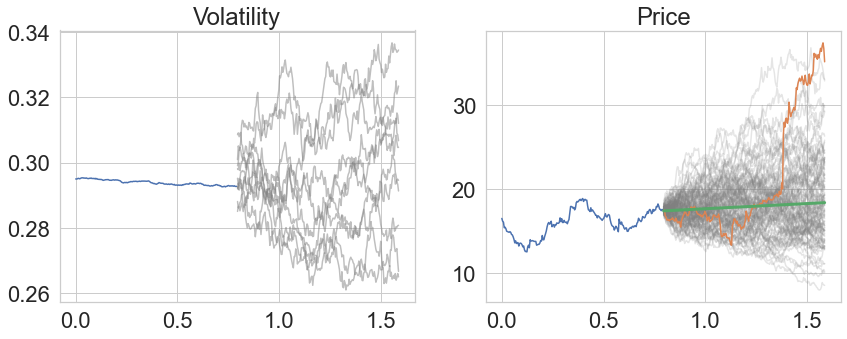

In [24]:
fig, ax = plt.subplots(1, 2, figsize = (14, 5))

ax[0].plot(train_x, pred_scale)
ax[0].plot(test_x, vol_paths.t(), color = "gray", alpha = 0.5)

ax[1].plot(test_x, px_paths.t(), color = "gray", alpha = 0.2)
ax[1].plot(train_x, train_y)
ax[1].plot(test_x, test_y)
ax[1].plot(test_x, voltron.mean_module(test_x).detach().exp(), lw=3.)

ax[0].set_title("Volatility")
ax[1].set_title("Price")

plt.show();